# Model: Logistic Regression Gender Only

https://www.kaggle.com/c/titanic/overview

**Initialization**

In [323]:
%run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
from data.data import ExtractData, TransformData
from visualization.visualize import importance_plotting
from models import predict_model as pm
from zeetle.data import eda

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn import metrics

RANDOM_STATE = 42

## Define

In [325]:
def rank_features_by_logreg_coefficients(X_train, logreg, abs_threshold = 0.5):
    
    fi = {'Features':X_train.columns.tolist(), 'Importance':np.transpose(logreg.coef_[0])}

    importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False).set_index('Features').sort_values(by='Importance', ascending=False)

    mask = abs(importance['Importance'])>abs_threshold

    with pd.option_context('display.max_rows', len(importance)):
        display(importance[mask])
    
    # Creating graph title
    titles = ['The most important features in predicting survival on the Titanic: Logistic Regression']

    # Plotting graph
    importance_plotting(importance.reset_index(), 'Importance', 'Features', 'Reds_r', titles)
    
    important_features = importance[mask].index.tolist()
    unimportant_features = importance[~mask].index.tolist()
    return important_features, unimportant_features

In [290]:
def calc_logreg_model(X_train, y_train):

    print('feature list ...')
    print(f'{X_train.columns.tolist()}\n')
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train) 

    y_pred = pd.Series(logreg.predict(X_test), 
                       index=y_test.index, name='survived_pred').to_frame()

    scores = cross_val_score(logreg, X_train, y_train, cv=10)
    print(f"Cross Validation Accuracy Scores: {scores}")
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    
    return logreg, y_pred

## Extract Clean Data

**Separate data into X (features) and y (label)**

In [328]:
train_raw = ExtractData('../data/raw/train.csv')
train = TransformData(train_raw)

In [329]:
eda.stat_nan(train_raw.Xy_raw)
eda.stat_nan(train.Xy)

,survived,pclass,name,sex,age_known,sibsp,parch,ticket,fare,cabin,embarked
True,891,891,891,891,714,891,891,891,891,204,889
False,0,0,0,0,177,0,0,0,0,687,2
Total,891,891,891,891,891,891,891,891,891,891,891


,survived,pclass,name,sex,age_known,sibsp,parch,ticket,fare,cabin,embarked,title,last_name,cabin_number,cabin_prefix,age_estimate,age,age_bin,is_child,is_travelling_alone
True,891,891,891,891,714,891,891,891,891,204,891,891,891,887,226,891,891,891,891,891
False,0,0,0,0,177,0,0,0,0,687,0,0,0,4,665,0,0,0,0,0
Total,891,891,891,891,891,891,891,891,891,891,891,891,891,891,891,891,891,891,891,891


In [330]:
features = [ 'sex']
labels = ['survived']
Xy = train.Xy[features + labels]

In [331]:
Xy

,sex,survived
passengerid,,
1,male,0
5,male,0
6,male,0
7,male,0
13,male,0
...,...,...
825,male,0
828,male,1
832,male,1


## Encode Categorical Columns

In [332]:
encoded_features = ['sex']

Xy_encoded = (pd.get_dummies(Xy, columns=encoded_features, drop_first=True)
              #.drop(['sex_male', 'pclass_2'], axis=1)
             )
Xy_encoded 

,survived,sex_male
passengerid,,
1,0,1
5,0,1
6,0,1
7,0,1
13,0,1
...,...,...
825,0,1
828,1,1
832,1,1


## Train Test Split Data

In [333]:
X = Xy_encoded.drop('survived', axis=1)
y = Xy_encoded['survived']

#X = Xy.drop('survived', axis=1)
#y = Xy['survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f'Number of sample in training data = {len(X_train)}')
print(f'Number of sample in test data = {len(X_test)}')

Number of sample in training data = 712
Number of sample in test data = 179


### Logistic Regression

In [334]:
logreg, y_pred = calc_logreg_model(X_train, y_train);

feature list ...
['sex_male']

Cross Validation Accuracy Scores: [0.70833333 0.77777778 0.77777778 0.8028169  0.76056338 0.76056338
 0.83098592 0.71830986 0.78873239 0.87142857]
Accuracy: 0.7797 (+/- 0.0922)


### Calculate Metrics

In [335]:
Xy_test = pm.concat_to_create_xy_test(X_test, y_test, y_pred)
pm.calc_metrics(Xy_test)

print(metrics.classification_report(y_test, y_pred))

{'log_loss': 6.367546454726678, 'accuracy': 0.8156424581005587}

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       116
           1       0.76      0.70      0.73        63

    accuracy                           0.82       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.82      0.81       179



##  Feature Importance

The feature importance is accomplished by comparing the logistic regression coefficients. Joshua Reed demonstrated this in his kernel.  
https://www.kaggle.com/josh24990/simple-end-to-end-ml-workflow-top-5-score

,Importance
Features,
sex_male,-2.341804


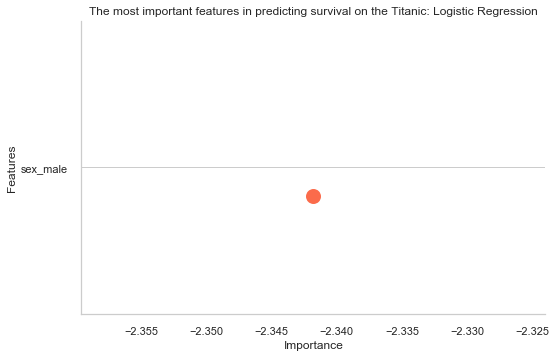

['sex_male']

In [336]:
important_features, unimportant_features = rank_features_by_logreg_coefficients(X_train, logreg, abs_threshold = 0.3)
important_features

## Recalculate Metrics

In [337]:
unimportant_features

[]

In [338]:
X = Xy_encoded[important_features]
y = Xy_encoded['survived']
X

#X = Xy.drop('survived', axis=1)
#y = Xy['survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f'Number of sample in training data = {len(X_train)}')
print(f'Number of sample in test data = {len(X_test)}')

,sex_male
passengerid,
1,1
5,1
6,1
7,1
13,1
...,...
825,1
828,1
832,1


Number of sample in training data = 712
Number of sample in test data = 179


In [339]:
logreg_important, y_pred = calc_logreg_model(X_train, y_train);

feature list ...
['sex_male']

Cross Validation Accuracy Scores: [0.70833333 0.77777778 0.77777778 0.8028169  0.76056338 0.76056338
 0.83098592 0.71830986 0.78873239 0.87142857]
Accuracy: 0.7797 (+/- 0.0922)


In [347]:
Xy_test = pm.concat_to_create_xy_test(X_test, y_test, y_pred)
pm.calc_metrics(Xy_test)

print(metrics.classification_report(y_test, y_pred, target_names=['female', 'male']))

{'log_loss': 6.367546454726678, 'accuracy': 0.8156424581005587}

              precision    recall  f1-score   support

      female       0.84      0.88      0.86       116
        male       0.76      0.70      0.73        63

    accuracy                           0.82       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.82      0.81       179



,Importance
Features,
sex_male,-2.341804


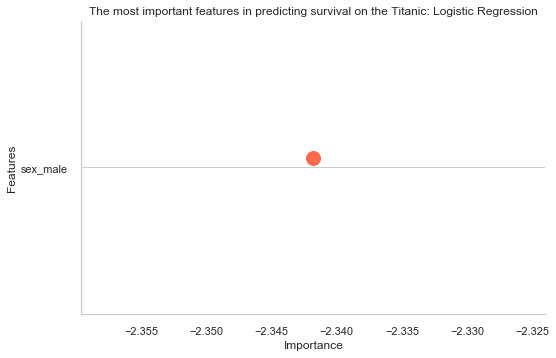

['sex_male']

In [341]:
important_features, unimportant_features = rank_features_by_logreg_coefficients(X_train, logreg_important, abs_threshold = 0)
important_features

# Prepare Submission

In [342]:
holdout_raw =  ExtractData('../data/raw/holdout.csv')
holdout = TransformData(holdout_raw, 
                        fare_mode = train.fare_mode, 
                        embarked_mode = train.embarked_mode, 
                        age_bins = train.age_bins, 
                        Xy_age_estimate = train.Xy_age_estimate)

In [309]:
eda.stat_nan(holdout_raw.Xy_raw)
eda.stat_nan(holdout.Xy)

,pclass,name,sex,age_known,sibsp,parch,ticket,fare,cabin,embarked
True,418,418,418,332,418,418,418,417,91,418
False,0,0,0,86,0,0,0,1,327,0
Total,418,418,418,418,418,418,418,418,418,418


,pclass,name,sex,age_known,sibsp,parch,ticket,fare,cabin,embarked,title,last_name,cabin_number,cabin_prefix,age_estimate,age,age_bin,is_child,is_travelling_alone
True,418,418,418,332,418,418,418,418,91,418,418,418,418,122,418,418,418,418,418
False,0,0,0,86,0,0,0,0,327,0,0,0,0,296,0,0,0,0,0
Total,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418


In [310]:
Xy_holdout = holdout.Xy[features].sort_index()
Xy_holdout

,pclass,sex,title,embarked,age_bin,is_child,is_travelling_alone
passengerid,,,,,,,
892,3,male,Mr,Q,"(30.0, 40.0]",False,True
893,3,female,Mrs,S,"(40.0, 50.0]",False,False
894,2,male,Mr,Q,"(60.0, inf]",False,True
895,3,male,Mr,S,"(20.0, 30.0]",False,True
896,3,female,Mrs,S,"(20.0, 30.0]",False,False
...,...,...,...,...,...,...,...
1305,3,male,Mr,S,"(30.0, 40.0]",False,True
1306,1,female,Mrs,C,"(30.0, 40.0]",False,True
1307,3,male,Mr,S,"(30.0, 40.0]",False,True


In [311]:
important_features

['title_Mrs',
 'is_child_True',
 'age_bin_(10.0, 20.0]',
 'age_bin_(20.0, 30.0]',
 'title_Miss',
 'age_bin_(30.0, 40.0]',
 'is_travelling_alone_True',
 'age_bin_(50.0, 60.0]',
 'age_bin_(60.0, inf]',
 'embarked_S',
 'pclass_2',
 'pclass_3',
 'title_Mr']

In [312]:
X_holdout = (pd.get_dummies(Xy_holdout, columns=encoded_features, drop_first=True)
            [important_features]
              #.drop(['sex_male', 'pclass_2'], axis=1)
             )
set(X_holdout.columns.tolist())

X_holdout

{'age_bin_(10.0, 20.0]',
 'age_bin_(20.0, 30.0]',
 'age_bin_(30.0, 40.0]',
 'age_bin_(50.0, 60.0]',
 'age_bin_(60.0, inf]',
 'embarked_S',
 'is_child_True',
 'is_travelling_alone_True',
 'pclass_2',
 'pclass_3',
 'title_Miss',
 'title_Mr',
 'title_Mrs'}

,title_Mrs,is_child_True,"age_bin_(10.0, 20.0]","age_bin_(20.0, 30.0]",title_Miss,"age_bin_(30.0, 40.0]",is_travelling_alone_True,"age_bin_(50.0, 60.0]","age_bin_(60.0, inf]",embarked_S,pclass_2,pclass_3,title_Mr
passengerid,,,,,,,,,,,,,
892,0,0,0,0,0,1,1,0,0,0,0,1,1
893,1,0,0,0,0,0,0,0,0,1,0,1,0
894,0,0,0,0,0,0,1,0,1,0,1,0,1
895,0,0,0,1,0,0,1,0,0,1,0,1,1
896,1,0,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,0,0,0,0,1,1,0,0,1,0,1,1
1306,1,0,0,0,0,1,1,0,0,0,0,0,0
1307,0,0,0,0,0,1,1,0,0,1,0,1,1


In [313]:
y_pred = logreg_important.predict(X_holdout)

y_holdout = pd.Series(y_pred, index=X_holdout.index, name='Survived').to_frame().sort_index()
y_holdout.index.names = ['PassengerId']
y_holdout

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [314]:
y_kaggle_submission = (pd.read_csv('../data/raw/gender_submission.csv')
                       .set_index('PassengerId')
                       .sort_index()
               )
y_kaggle_submission

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [315]:
(y_kaggle_submission.index == y_holdout.index).all()
y_kaggle_submission.index.names == y_holdout.index.names
(y_kaggle_submission.columns == y_holdout.columns).all()

True

True

True

In [316]:
y_holdout.to_csv('logres_important_v3.csv')

In [322]:
lr1 = pd.read_csv('logres_important_v2.csv').set_index('PassengerId').sort_index()
lr2 = pd.read_csv('logres_important_v3.csv').set_index('PassengerId').sort_index()

lr = lr1.join(lr2, lsuffix='_1', rsuffix='_2')
lr['is_equal'] = lr['Survived_1'] == lr['Survived_2']

lr.is_equal.value_counts()

True     386
False     32
Name: is_equal, dtype: int64